## import


In [11]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModel, 
    BertPreTrainedModel, 
    TrainingArguments, 
    Trainer
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

✅ GPU is available. Device: NVIDIA GeForce RTX 3080 Ti


## setting


In [12]:
# --- 2. 設定 ---

# 訓練データセットのパス
# (Dockerコンテナ内のパス、またはローカルの相対パス)
TRAINING_FILE = "data/processed/training_dataset_abstract.csv"

# 使用するベースモデル（SciBERT）
MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"

# 訓練済みモデルの保存先
OUTPUT_MODEL_DIR = "models/siamese_scibert_smoketest"

# モデルのハイパーパラメータ
MAX_LENGTH = 512       # アブストラクト1件あたりの最大長
BATCH_SIZE = 4         # 動作確認用の小さなバッチサイズ
EPOCHS = 1             # 1エポックで十分
LEARNING_RATE = 2e-5
# ▼▼▼ 動作確認用の設定 ▼▼▼
SMOKE_TEST_SIZE = 200 # 読み込むデータ件数を200件に制限
MAX_TRAIN_STEPS = 10  # 10ステップで訓練を強制終了

print("Configuration set for SMOKE TEST.")

Configuration set for SMOKE TEST.


## モデル


In [13]:
# --- 3. カスタムモデルクラスの定義 ---

class MeanPooling(nn.Module):
    """アテンションマスクを考慮したMean Pooling層"""
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

class SiameseSciBERT(BertPreTrainedModel):
    """
    手法1：二入力ベクトル比較型（Siamese-SciBERT）
    """
    def __init__(self, config):
        super(SiameseSciBERT, self).__init__(config)
        self.bert = AutoModel.from_config(config)
        self.pooler = MeanPooling()
        # 特徴量 [x, y, |x-y|, x*y] を連結するため、入力サイズは (config.hidden_size * 4)
        self.classifier = nn.Linear(config.hidden_size * 4, config.num_labels)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        input_ids_b=None,
        attention_mask_b=None,
        labels=None,
        **kwargs
    ):
        # 論文Aと論文Bを、同じ重みのBERTで個別に処理
        output_a = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output_b = self.bert(input_ids=input_ids_b, attention_mask=attention_mask_b)

        # Mean Poolingでベクトル化
        vec_x = self.pooler(output_a.last_hidden_state, attention_mask)
        vec_y = self.pooler(output_b.last_hidden_state, attention_mask_b)

        # 特徴量の作成
        diff = torch.abs(vec_x - vec_y)
        prod = vec_x * vec_y
        concatenated_features = torch.cat([vec_x, vec_y, diff, prod], dim=1)

        # 分類
        logits = self.classifier(concatenated_features)

        # 損失の計算
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return SequenceClassifierOutput(loss=loss, logits=logits)

print("Custom model class 'SiameseSciBERT' defined.")

Custom model class 'SiameseSciBERT' defined.


## データロードとトークナイズ


In [14]:
# --- 4. データセットの読み込みとトークン化 ---
print(f"Loading dataset (SMOKE TEST: {SMOKE_TEST_SIZE} rows)...")
df = pd.read_csv(TRAINING_FILE, nrows=SMOKE_TEST_SIZE)

df = df.dropna(subset=['abstract_a', 'abstract_b', 'label'])
df['label'] = df['label'].astype(int)
print(f"Loaded {len(df)} pairs.")

raw_dataset = Dataset.from_pandas(df)
dataset_split = raw_dataset.train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    'train': dataset_split['train'],
    'validation': dataset_split['test']
})
print(f"Dataset split: {dataset}")

# トークナイザのロード
print("Initializing tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

# トークン化関数
def tokenize_siamese_function(examples):
    tokenized_a = tokenizer(examples["abstract_a"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    tokenized_b = tokenizer(examples["abstract_b"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    # Trainerが 'input_ids' を必須とするため、'input_ids_a' を 'input_ids' にリネーム
    return {
        "input_ids": tokenized_a["input_ids"],
        "attention_mask": tokenized_a["attention_mask"],
        "input_ids_b": tokenized_b["input_ids"],
        "attention_mask_b": tokenized_b["attention_mask"],
    }

print("Tokenizing dataset for Siamese model...")
tokenized_datasets = dataset.map(tokenize_siamese_function, batched=True)

# 不要なカラムを削除し、Trainerが期待する形式に整形
tokenized_datasets = tokenized_datasets.remove_columns(["abstract_a", "abstract_b", "data_paper_doi"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
print("Tokenization complete.")

Loading dataset (SMOKE TEST: 200 rows)...
Loaded 200 pairs.
Dataset split: DatasetDict({
    train: Dataset({
        features: ['abstract_a', 'abstract_b', 'label', 'data_paper_doi'],
        num_rows: 160
    })
    validation: Dataset({
        features: ['abstract_a', 'abstract_b', 'label', 'data_paper_doi'],
        num_rows: 40
    })
})
Initializing tokenizer...


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing dataset for Siamese model...


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Tokenization complete.


## モデルのロードと訓練設定


In [15]:
# --- 5. モデルのロードと訓練設定 ---
print(f"Loading custom model: {MODEL_CHECKPOINT}")
model = SiameseSciBERT.from_pretrained(MODEL_CHECKPOINT, num_labels=2).to(device)
print("Custom model loaded.")

# 評価指標を計算する関数
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    # average='binary' (2クラス分類) を指定
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# 訓練の設定
training_args = TrainingArguments(
    output_dir=OUTPUT_MODEL_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    
    # 動作確認用の設定
    num_train_epochs=EPOCHS,     # 1エポック
    max_steps=MAX_TRAIN_STEPS, # 10ステップで強制終了
    
    evaluation_strategy="steps",   # ステップごとに評価
    eval_steps=5,                  # 5ステップごとに評価
    save_strategy="steps",
    save_steps=5,
    
    load_best_model_at_end=True,
    logging_steps=1, # 1ステップごとにログ出力
)
print("Training arguments set for SMOKE TEST.")

Loading custom model: allenai/scibert_scivocab_uncased


Some weights of SiameseSciBERT were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Custom model loaded.
Training arguments set for SMOKE TEST.


## 訓練開始


In [16]:
# --- 6. 訓練の開始 ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("\n--- Starting Model Training (SMOKE TEST) ---")
# 10ステップ（バッチ）だけ実行され、すぐに終わるはずです
trainer.train()
print("--- Model Training Complete ---")

max_steps is given, it will override any value given in num_train_epochs



--- Starting Model Training (SMOKE TEST) ---


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
5,0.006900,0.002453,1.000000,1.000000,1.000000,1.000000
10,0.000100,0.000239,1.000000,1.000000,1.000000,1.000000


--- Model Training Complete ---


## モデルの保存


In [17]:
# --- 7. モデルの保存 ---
print("Training complete. Saving best model...")
best_model_path = os.path.join(OUTPUT_MODEL_DIR, "best_model")
trainer.save_model(best_model_path)
print(f"Model saved to {best_model_path}")

Training complete. Saving best model...
Model saved to models/siamese_scibert_smoketest/best_model


## 訓練結果の可視化



--- Visualizing Training Results ---


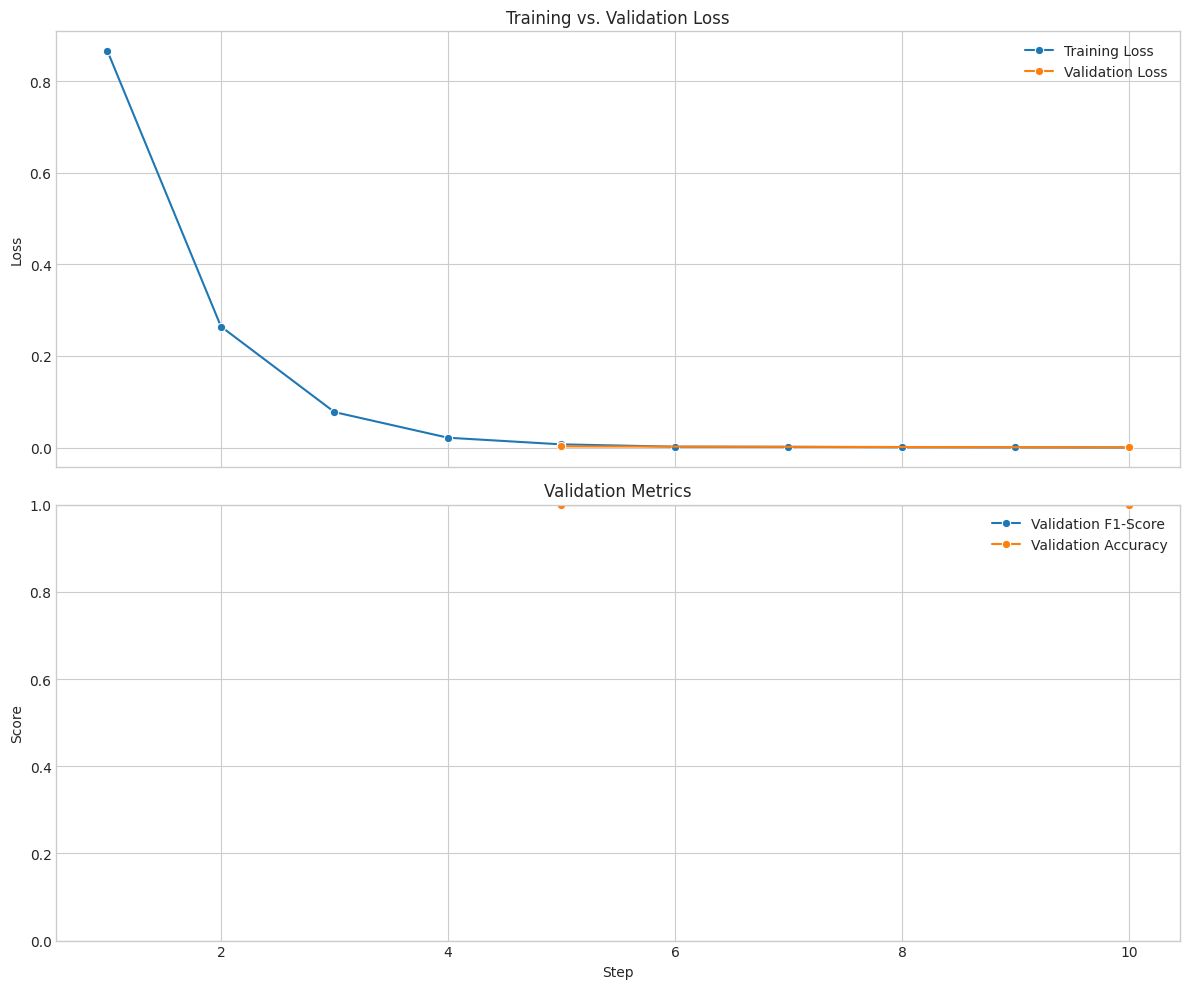


--- Best Model Evaluation Metrics (from validation set) ---
Best Step (based on min eval_loss): 10.0
Best Validation Loss: 0.0002
Best Validation F1: 1.0000
Best Validation Accuracy: 1.0000


In [19]:
# --- 8. 訓練結果の可視化 ---
print("\n--- Visualizing Training Results ---")
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)

df_train = df_log[df_log['loss'].notna()].copy()
df_eval = df_log[df_log['eval_loss'].notna()].copy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

if not df_train.empty:
    sns.lineplot(data=df_train, x='step', y='loss', label='Training Loss', ax=ax1, marker='o')
if not df_eval.empty:
    sns.lineplot(data=df_eval, x='step', y='eval_loss', label='Validation Loss', ax=ax1, marker='o')
ax1.set_title('Training vs. Validation Loss')
ax1.set_ylabel('Loss')
ax1.legend()

if not df_eval.empty:
    sns.lineplot(data=df_eval, x='step', y='eval_f1', label='Validation F1-Score', ax=ax2, marker='o')
    sns.lineplot(data=df_eval, x='step', y='eval_accuracy', label='Validation Accuracy', ax=ax2, marker='o')
ax2.set_title('Validation Metrics')
ax2.set_ylabel('Score')
ax2.set_xlabel('Step')
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# --- ▼▼▼ 修正点: best_metricの参照方法を変更 ▼▼▼ ---
print("\n--- Best Model Evaluation Metrics (from validation set) ---")

# df_eval (このセルの前半で作成した検証結果のDataFrame) を使用
if not df_eval.empty:
    # 'eval_loss' が最小だった行（=ベストモデル）を取得
    best_run = df_eval.loc[df_eval['eval_loss'].idxmin()]
    
    print(f"Best Step (based on min eval_loss): {best_run['step']}")
    print(f"Best Validation Loss: {best_run['eval_loss']:.4f}")
    print(f"Best Validation F1: {best_run['eval_f1']:.4f}")
    print(f"Best Validation Accuracy: {best_run['eval_accuracy']:.4f}")
else:
    print("No evaluation steps were completed.")